<img src="https://mt.mahidol.ac.th/wp-content/uploads/2019/10/OriginalLOGO.png">

## Imports

In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split,cross_validate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping 
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import normalize,LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error
from tensorflow.keras import Model
import numpy as np
from tqdm import tqdm
from matplotlib import style
style.use("ggplot")

## For each fingerprint file--- Combining File with pChEMBL Value and Running PCA

<p>Combining PCHEMPL Value for each fingerprint</p>

In [17]:
files=os.listdir(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints')##change the directory
df_STS_data=pd.read_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/STS_curatedFile.csv')
for dfs in files:
    df_orginal=pd.read_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints/{}'.format(dfs))##change the directory
    df_transformed=df_orginal.merge(df_STS_data[["Molecule.ChEMBL.ID","pChEMBL.Value"]],how="left",left_on="Name",right_on="Molecule.ChEMBL.ID")
    df_transformed.drop("Molecule.ChEMBL.ID",1,inplace=True)
    df_transformed.to_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints/transformed/{}--transformed.csv'.format(dfs))
    

<p>I want to combine each finger print into one dataframe therefore reducing the dimensions for each finger print through PCA after
running the previous model-1 PCA herustic to decide optimal N for each file and then saving the reduced dimensioned dataframe for combining in next cell</p>

In [12]:
def PCA_function(df,n_compnents,visual=True):
    Id=df["Name"]
    X=df.drop(["pChEMBL.Value","Name"],1)
    y=df["pChEMBL.Value"]
    pca=PCA(n_compnents)
    X_reduced=pca.fit_transform(X)
    ratio=pca.explained_variance_ratio_
    sums=np.sum(ratio)
    cummulative_sums=[]
    sums_cums=0
    for i in ratio:
        sums_cums+=i
        cummulative_sums.append(sums_cums)
    if visual:
        ax=plt.subplot(111)
        x_labels=[str(i) for i in range(n_compnents)]
        x_numeric=[i for i in range(n_compnents)]
        ax2 = ax.twinx()
        ax.bar(x_labels,ratio)
        ax2.plot(x_numeric,cummulative_sums,color="black")
        ax2.set_ylabel('Cumulative Variance', color='black')
        ax.set_title("Explained variance with n={}".format(n_compnents))
        ax.set_xlabel("Components")
        ax.set_ylabel("Ratio")
        plt.grid(False)
    return X_reduced,ratio,Id,y

In [10]:
def best_ncompnents(df,threshold):
    '''
    This function is used to optimize the number of components for PCA since there is infinite number of choice available.
    The herustic I have used to optimize the N-Component is simple, I ran the PCA for n-compenents ranging from 3 to 50 and then
    picked the variance explained by the newly added compenent. If this variance is significant enough than I kept on adding the
    component, but if  the variance explained by the last newly added component is below threshold,it become insignificant to add the 
    new component therefore function stops running.
    
    Please note that threshold is an hyperparameter given by the user....

    '''
    for n in range(3,50):
        _,ratio,_,_=PCA_function(df,n_compnents=n,visual=False)
        if ratio[-1]<threshold:
            return n

In [48]:
files_transformed=os.listdir(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints/transformed')##change the directory
for dfs in files_transformed:
    df=pd.read_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints/transformed/{}'.format(dfs))
    n=best_ncompnents(df,0.001)
    X_reduced,ratio,Id,y=PCA_function(df,n,visual=False)
    df_transformed_reduced=pd.DataFrame(X_reduced,columns=[str(i) for i in range(1,n+1)])
    df_transformed_reduced["pChEMBL.Value"]=y
    df_transformed_reduced["Name"]=Id
    df_transformed_reduced.to_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints/transformed-reduced/{}'.format(dfs))   

### Combining the Transformed Files into one dataframe after having reduced the dimensions for each fingerprint

In [3]:
df_combined=None
files_transformed=os.listdir(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints/transformed-reduced')##change the directory
s=-1
for dfs in tqdm(files_transformed):
    s+=1
    if s==0:
        df_transformed=pd.read_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints/transformed-reduced/{}'.format(dfs))
        df_combined=df_transformed
    else:
        df_transformed=pd.read_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/STS-dataset/fingerprints/transformed-reduced/{}'.format(dfs))
        df_combined=df_combined.merge(df_transformed,how="inner",on="Name")
df_combined.to_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/df_new_data_dl.csv')

100%|██████████| 12/12 [00:17<00:00,  1.46s/it]


In [4]:
df_combined=pd.read_csv(r'C:/Users/MMOHTASHIM/Anaconda3/libs/Research/df_new_data_dl.csv')

### Further Preprocessing of df_combined

In [5]:
df_combined.columns.tolist()

['Unnamed: 0',
 'Unnamed: 0_x',
 '1_x',
 '2_x',
 '3_x',
 'pChEMBL.Value_x',
 'Name',
 'Unnamed: 0_y',
 '1_y',
 '2_y',
 '3_y',
 '4_x',
 '5_x',
 '6',
 '7',
 'pChEMBL.Value_y',
 'Unnamed: 0_x.1',
 '1_x.1',
 '2_x.1',
 '3_x.1',
 'pChEMBL.Value_x.1',
 'Unnamed: 0_y.1',
 '1_y.1',
 '2_y.1',
 '3_y.1',
 'pChEMBL.Value_y.1',
 'Unnamed: 0_x.2',
 '1_x.2',
 '2_x.2',
 '3_x.2',
 'pChEMBL.Value_x.2',
 'Unnamed: 0_y.2',
 '1_y.2',
 '2_y.2',
 '3_y.2',
 'pChEMBL.Value_y.2',
 'Unnamed: 0_x.3',
 '1_x.3',
 '2_x.3',
 '3_x.3',
 'pChEMBL.Value_x.3',
 'Unnamed: 0_y.3',
 '1_y.3',
 '2_y.3',
 '3_y.3',
 '4_y',
 '5_y',
 'pChEMBL.Value_y.3',
 'Unnamed: 0_x.4',
 '1_x.4',
 '2_x.4',
 '3_x.4',
 'pChEMBL.Value_x.4',
 'Unnamed: 0_y.4',
 '1_y.4',
 '2_y.4',
 '3_y.4',
 'pChEMBL.Value_y.4',
 'Unnamed: 0_x.5',
 '1_x.5',
 '2_x.5',
 '3_x.5',
 'pChEMBL.Value_x.5',
 'Unnamed: 0_y.5',
 '1_y.5',
 '2_y.5',
 '3_y.5',
 '4',
 'pChEMBL.Value_y.5']

In [6]:
df_combined.drop(['Unnamed: 0','Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0_x.1',
                 'Unnamed: 0_x.2','Unnamed: 0_x.3','Unnamed: 0_y.2','Unnamed: 0_y.3',
                 'Unnamed: 0_x.4','Unnamed: 0_y.4','Unnamed: 0_x.5','Unnamed: 0_y.5','pChEMBL.Value_y.5',
                 'pChEMBL.Value_x.5','pChEMBL.Value_y.4','pChEMBL.Value_x.4','pChEMBL.Value_y.3','pChEMBL.Value_x.3',
                 'pChEMBL.Value_y.2','pChEMBL.Value_x.2','pChEMBL.Value_y.1','pChEMBL.Value_x.1','pChEMBL.Value_y'],1,inplace=True)

In [7]:
df_combined.head()

,1_x,2_x,3_x,pChEMBL.Value_x,Name,1_y,2_y,3_y,4_x,5_x,...,1_y.4,2_y.4,3_y.4,1_x.5,2_x.5,3_x.5,1_y.5,2_y.5,3_y.5,4
0,-358.499856,-0.287388,-0.638643,5.47,CHEMBL420395,358.940219,-35.171909,-7.099436,-3.839054,-2.708396,...,357.502285,2.717889,-0.551374,-357.500074,0.461223,-0.282063,356.534793,-4.618440,-8.782333,-4.496614
1,-358.499856,-0.287388,-0.638643,5.47,CHEMBL420395,358.940219,-35.171909,-7.099436,-3.839054,-2.708396,...,357.502285,2.717889,-0.551374,-357.500074,0.461223,-0.282063,-3.462247,-4.720225,-9.275478,-5.720041
2,-358.499856,-0.287388,-0.638643,5.47,CHEMBL420395,358.940219,-35.171909,-7.099436,-3.839054,-2.708396,...,357.502285,2.717889,-0.551374,3.499792,0.440560,-0.419458,356.534793,-4.618440,-8.782333,-4.496614
3,-358.499856,-0.287388,-0.638643,5.47,CHEMBL420395,358.940219,-35.171909,-7.099436,-3.839054,-2.708396,...,357.502285,2.717889,-0.551374,3.499792,0.440560,-0.419458,-3.462247,-4.720225,-9.275478,-5.720041
4,-358.499856,-0.287388,-0.638643,5.47,CHEMBL420395,358.940219,-35.171909,-7.099436,-3.839054,-2.708396,...,-3.496959,2.866700,-0.479875,-357.500074,0.461223,-0.282063,356.534793,-4.618440,-8.782333,-4.496614


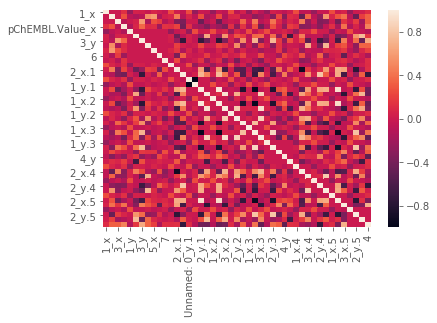

In [8]:
sns.heatmap(df_combined.corr())

In [ ]:
df_combined=df_combined.rename(columns={"pChEMBL.Value_x":"pChEMBL.Value"})
best_ncompnents(df_combined,threshold=0.01)

In [ ]:
X,_,_,y=PCA_function(df_combined,13,visual=True) 
np.save("X.npy",X)
np.save("y.npy",y)

In [25]:
def deep_learning_model():
    
    inputs = Input(shape=(13,))
    a_1 = Dense(32,activation="relu")(inputs)
    a_2 = Dense(128,activation="relu")(a_1)
    output=Dense(1,activation="linear")(a_2)
    
    model =Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
                 loss='mean_squared_error')
    
    print(model.summary())
    return model


In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1)
checkpoint=ModelCheckpoint(r"C:\Users\MMOHTASHIM\Anaconda3\libs\IBM Capstone",monitor='val_loss', save_best_only=False)
earlystop=EarlyStopping(monitor='val_loss', min_delta=0, patience=2)
model=deep_learning_model()
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1)
history=model.fit(X_train,y_train,epochs=5,validation_data=(X_val,y_val),callbacks=[checkpoint,earlystop])
ax=plt.subplot(111)
ax.plot(history.history["loss"],label="loss")
ax.plot(history.history["val_loss"],label="validation_loss")
ax.set_title("Loss Over Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.legend()

In [ ]:
model.save("DeepLearning-Model V1.h5")

### Scrambled vs Orginal Performance Benchmark on Deep Learning Model

In [ ]:
def scrambled_pair_prediction(Deep_learning_algorithm,X_reduced,y,trials):
    style.use("classic")
    
    
    clf=Deep_learning_algorithm

    r2_test_scrambled=[]
    r2_test_orginal=[]
    r2_train_orginal=[]
    r2_train_scrambled=[]
    y_train_combined=[]
    y_train_scrambled_combined=[]
    y_test_combined=[]
    y_test_scrambled_combined=[]

    
    for i in range(10):##10 time shuffled
        X_shuffled=np.copy(X_reduced)
        y_shuffled=np.copy(y)
        np.random.shuffle(X_shuffled)
        np.random.shuffle(y_shuffled)
        X_train_scrambled,X_test_scrambled,y_train_scrambled,y_test_scrambled=train_test_split(X_shuffled,y_shuffled,test_size=0.2)##80/20 indpedent split on scrambled data
        
        X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.2)##80/20 indpedent split on orginal
        y_test_scrambled_combined.append(clf.predict(X_test_scrambled))
        y_test_combined.append(clf.predict(X_test))
        y_train_combined.append(clf.predict(X_train))
        y_train_scrambled_combined.append(clf.predict(X_train_scrambled))
        for i in range(trials):##for each shuffled ,run this many times of this trial and collect the revelant for later plotting
            r2_test_scrambled.append(r2_score(y_test_scrambled,y_pred_test_scrambled_trial))
            r2_test_orginal.append(r2_score(y_test,y_pred_test_trial))


            r2_train_scrambled.append(r2_score(y_train_scrambled,y_pred_train_scrambled_trial))
            r2_train_orginal.append(r2_score(y_train,y_pred_train_trial))
        
    
    fig=plt.figure()
    fig.set_facecolor('white')
    fig.set_size_inches(14,14)
    ax1=fig.add_subplot(211)
    ax2=fig.add_subplot(212)
   
        
    ax1.grid(False)
    ax2.grid(False)

    
    ax1.scatter(np.array(y_test_combined),np.array(y_pred_test).reshape(-1,),c='red',label='Orginal')
    ax1.set_title('Predicted vs Orginal pChEMBL--Test Data')
    
    
    ax1.scatter(np.array(y_test_scrambled_combined), np.array(y_pred_test_scrambled).reshape(-1,),c='blue',label='Scrambled')
    
    
    
    ax2.scatter(np.array(r2_test_scrambled),np.array(r2_test_orginal).reshape(-1,),c='red',label="test")
    ax2.set_title('R2 for Scrambled vs Orginal')
    
    ax2.scatter(np.array(r2_train_scrambled),np.array(r2_train_orginal).reshape(-1,),c='blue',label="train")
   
    
#     fig.text(0.02, 0.5, 'Predicted pChEMBL', ha='center',fontweight="bold")
#     fig.text(0.5,0.5,'R2-Orginal',ha='center',fontweight="bold")
    
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    ax1.set_xlabel("Experimental pChEMBL",fontweight="bold")
    ax2.set_xlabel("R2-Scrambled",fontweight="bold")
    
    
    ax1.set_ylabel("Predicted pChEMBL",fontweight="bold")
    ax2.set_ylabel("R2-Orginal",fontweight="bold")
    

In [ ]:
X=np.load("X.npy")
y=np.load("y.npy")
model = load_model('DeepLearning-Model V1.h5')
scrambled_pair_prediction(model,X,y,1)

### Deep Learning Model Metric MSE and R2

In [ ]:
def deep_learning_train():

    r2_train=[]
    r2_test=[]
    mse_train=[]
    mse_test=[]
    
    for i in range(10):

        checkpoint=ModelCheckpoint(r"C:\Users\MMOHTASHIM\Anaconda3\libs\IBM Capstone",monitor='val_loss', save_best_only=False)
        earlystop=EarlyStopping(monitor='val_loss', min_delta=0, patience=2)
        clf=deep_learning_model()
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
        clf.fit(X_train,y_train,epochs=20,validation_data=(X_val,y_val),callbacks=[checkpoint,earlystop])
            
        y_pred_train=clf.predict(X_train)
        y_pred_test=clf.predict(X_test)##testing
        
        r2_train.append(r2_score(y_train,y_pred_train))
        r2_test.append(r2_score(y_test,y_pred_test))
        mse_train.append(mean_squared_error(y_train,y_pred_train))
        mse_test.append(mean_squared_error(y_test,y_pred_test))
        
        
    print("The mean R2 score for {} is {}--Train".format("Deep Learning Model is",np.mean(r2_train)))
    print("The mean R2 score for {} is {}--Test".format("Deep Learning Model is",np.mean(r2_test)))
    
    print("The mean MSE score for {} is {}--Train".format("Deep Learning Model is",np.mean(mse_train)))
    print("The mean MSE score for {} is {}--Test".format("Deep Learning Model is",np.mean(mse_test)))
    
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(11,8)
    axs[0, 0].plot(list(range(trials)), r2_train,'tab:red')
    axs[0, 0].set_title('R2--Score--Train--{}--trials'.format(trials))
    axs[0, 0].set_ylabel("R2 Score")
    
    
    
    axs[0, 1].plot(list(range(trials)), r2_test, 'tab:orange')
    axs[0, 1].set_title('R2--Score--Test--{}--trials'.format(trials))
    axs[1, 0].plot(list(range(trials)), mse_train,'tab:blue')
    
    
    axs[1, 0].set_title('MSE--Score--Train--{}--trials'.format(trials))
    axs[1, 0].set_ylabel("MSE Score")
    axs[1, 0].set_xlabel("Trials")
    axs[1, 1].plot(list(range(trials)), mse_test,'tab:purple')
    axs[1, 1].set_title('MSE--Score--Test--{}--trials'.format(trials))
    axs[1, 1].set_xlabel("Trials")
    
    
    axs[0,0].set_ylim([0,1])
    axs[0,1].set_ylim([0,1])
    axs[1,0].set_ylim([0,2])
    axs[1,1].set_ylim([0,2])
    plt.grid(False)
    
    return (r2_train,r2_test,mse_train,mse_test)
   
    
    

In [ ]:
deep_learning_train()